# Settings

In [1]:
EXP_NO = 12
SEED = 1
N_SPLITS = 5
TARGET = 'target'
GROUP = 'art_series_id'
REGRESSION = True

In [2]:
assert((TARGET, REGRESSION) in (('target', True), ('target', False), ('sorting_date', True)))

In [3]:
MODEL_NAME = 'resnet'
BATCH_SIZE = 128
NUM_EPOCHS = 50

# Library

In [4]:
from collections import defaultdict
from functools import partial
import gc
import glob
import json
from logging import getLogger, StreamHandler, FileHandler, DEBUG, Formatter
import pickle
import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, mean_squared_error, cohen_kappa_score
from sklearnex import patch_sklearn
from pytorch_lightning import seed_everything
import torch.nn as nn
import torch.optim
from torch.utils.data import DataLoader
from torchvision import transforms

SCRIPTS_DIR = os.path.join('..', 'scripts')
assert(os.path.isdir(SCRIPTS_DIR))
if SCRIPTS_DIR not in sys.path: sys.path.append(SCRIPTS_DIR)

from cross_validation import load_cv_object_ids
from dataset import load_csvfiles, load_photofile,load_photofiles, AtmaImageDatasetV02
from folder import experiment_dir_of
from models import initialize_model
from utils import train_model, predict_by_model

In [5]:
pd.options.display.float_format = '{:.5f}'.format

In [6]:
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Prepare directory

In [7]:
output_dir = experiment_dir_of(EXP_NO)

In [8]:
output_dir

'..\\scripts\\..\\experiments\\exp012'

# Prepare logger

In [9]:
logger = getLogger(__name__)

In [10]:
'''Refference
https://docs.python.org/ja/3/howto/logging-cookbook.html
'''
logger.setLevel(DEBUG)
# create file handler which logs even debug messages
fh = FileHandler(os.path.join(output_dir, 'log.log'))
fh.setLevel(DEBUG)
# create console handler with a higher log level
ch = StreamHandler()
ch.setLevel(DEBUG)
# create formatter and add it to the handlers
formatter = Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
ch.setFormatter(formatter)
# add the handlers to the logger
logger.addHandler(fh)
logger.addHandler(ch)
len(logger.handlers)

2

In [11]:
logger.info('Experiment no: {}'.format(EXP_NO))
logger.info('CV: StratifiedGroupKFold')
logger.info('SEED: {}'.format(SEED))
logger.info('REGRESSION: {}'.format(REGRESSION))

2021-07-20 10:12:12,016 - __main__ - INFO - Experiment no: 12
2021-07-20 10:12:12,017 - __main__ - INFO - CV: StratifiedGroupKFold
2021-07-20 10:12:12,018 - __main__ - INFO - SEED: 1
2021-07-20 10:12:12,018 - __main__ - INFO - REGRESSION: True


# Load csv files

In [12]:
SINCE = time.time()

In [13]:
logger.debug('Start loading csv files ({:.3f} seconds passed)'.format(time.time() - SINCE))
train, test, materials, techniques, sample_submission = load_csvfiles()
logger.debug('Complete loading csv files ({:.3f} seconds passed)'.format(time.time() - SINCE))

2021-07-20 10:12:12,079 - __main__ - DEBUG - Start loading csv files (0.035 seconds passed)
2021-07-20 10:12:12,118 - __main__ - DEBUG - Complete loading csv files (0.074 seconds passed)


In [14]:
train

,object_id,sorting_date,art_series_id,target
0,002bff09b09998d0be65,1631,509357f67692a6a45626,1
1,00309fb1ef05416f9c1f,1900,7987b47bbe5dc3039179,3
2,003a1562e97f79ba96dc,1834,ded7c3c9636708e5b14c,3
3,004890880e8e7431147b,1743,582ac2d7f0cef195b605,2
4,00718c32602425f504c1,1885,64c907f0c08dce4fb8e8,3
...,...,...,...,...
3932,ffa3259fff8e6f3818a1,1850,b187c294b0550acf049a,3
3933,ffd4d361756587883e48,1670,ad49a044770a48f860a6,1
3934,ffd794b7b311b7b7fd92,1789,f030a01b480b18a27be2,2
3935,ffe49bba69d06446de7e,1805,f5287bc84a05aada1d17,3


In [15]:
test

,object_id
0,0009e50b94be36ccad39
1,000bd5e82eb22f199f44
2,0015f44de1854f617516
3,00388a678879ba1efa27
4,005e1e7c6496902d23f3
...,...
5914,ffbe65ad399b632dcbd0
5915,ffd7b2d646c0320c311a
5916,ffdb93ede17d4501e530
5917,ffe111402004b0ed46b4


# Cross validation

In [16]:
seed_everything(SEED)

Global seed set to 1


1

In [17]:
train.set_index('object_id', inplace=True)

2021-07-20 10:12:12,206 - __main__ - DEBUG - Start fold 1 (0.162 seconds passed)
2021-07-20 10:12:12,209 - __main__ - DEBUG - Start training model (0.165 seconds passed)
2021-07-20 10:12:12,392 - __main__ - DEBUG - Epoch 0/49
C:\Users\nndropout\miniconda3\envs\atmacup11\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
2021-07-20 10:15:30,364 - __main__ - DEBUG - train Loss: 2.9940
2021-07-20 10:15:48,940 - __main__ - DEBUG - val Loss: 2.3390
2021-07-20 10:15:49,003 - __main__ - DEBUG - Epoch 1/49
2021-07-20 10:19:07,457 - __main__ - DEBUG - train Loss: 0.8812
2021-07-20 10:19:26,231 - __main__ - DEBUG - val Loss: 0.8537
2021-07-20 10:19:26,246 - __main__ - DEBUG -

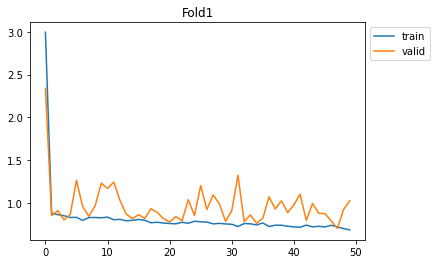

2021-07-20 13:16:47,489 - __main__ - DEBUG - Save training fold to ..\scripts\..\experiments\exp012\cv_fold1_training.csv (11075.445 seconds passed)
2021-07-20 13:16:47,500 - __main__ - DEBUG - Save validation fold to ..\scripts\..\experiments\exp012\cv_fold1_validation.csv (11075.455 seconds passed)
2021-07-20 13:16:47,503 - __main__ - DEBUG - Save test result ..\scripts\..\experiments\exp012\cv_fold1_test.csv (11075.458 seconds passed)
2021-07-20 13:16:47,549 - __main__ - DEBUG - Save model ..\scripts\..\experiments\exp012\cv_fold1_model.torch (11075.505 seconds passed)
2021-07-20 13:16:47,628 - __main__ - DEBUG - Complete fold 1 (11075.584 seconds passed)
2021-07-20 13:16:47,628 - __main__ - DEBUG - Start fold 2 (11075.584 seconds passed)
2021-07-20 13:16:47,628 - __main__ - DEBUG - Start training model (11075.584 seconds passed)
2021-07-20 13:16:47,769 - __main__ - DEBUG - Epoch 0/49
2021-07-20 13:20:08,945 - __main__ - DEBUG - train Loss: 2.1157
2021-07-20 13:20:27,342 - __main__ 

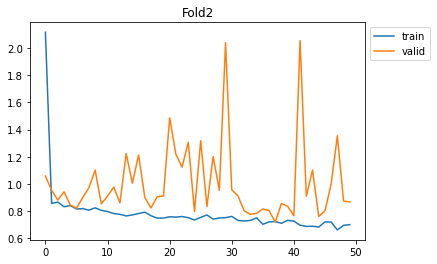

2021-07-20 16:22:11,962 - __main__ - DEBUG - Save training fold to ..\scripts\..\experiments\exp012\cv_fold2_training.csv (22199.918 seconds passed)
2021-07-20 16:22:12,007 - __main__ - DEBUG - Save validation fold to ..\scripts\..\experiments\exp012\cv_fold2_validation.csv (22199.963 seconds passed)
2021-07-20 16:22:12,007 - __main__ - DEBUG - Save test result ..\scripts\..\experiments\exp012\cv_fold2_test.csv (22199.963 seconds passed)
2021-07-20 16:22:12,062 - __main__ - DEBUG - Save model ..\scripts\..\experiments\exp012\cv_fold2_model.torch (22200.018 seconds passed)
2021-07-20 16:22:12,117 - __main__ - DEBUG - Complete fold 2 (22200.073 seconds passed)
2021-07-20 16:22:12,117 - __main__ - DEBUG - Start fold 3 (22200.073 seconds passed)
2021-07-20 16:22:12,117 - __main__ - DEBUG - Start training model (22200.073 seconds passed)
2021-07-20 16:22:12,243 - __main__ - DEBUG - Epoch 0/49
2021-07-20 16:25:32,683 - __main__ - DEBUG - train Loss: 2.1568
2021-07-20 16:25:51,315 - __main__ 

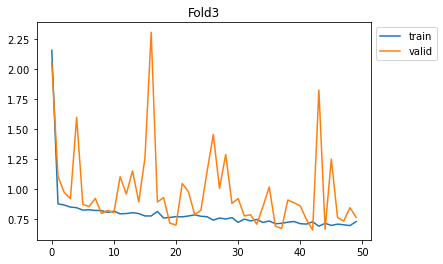

2021-07-20 19:26:42,078 - __main__ - DEBUG - Save training fold to ..\scripts\..\experiments\exp012\cv_fold3_training.csv (33270.033 seconds passed)
2021-07-20 19:26:42,081 - __main__ - DEBUG - Save validation fold to ..\scripts\..\experiments\exp012\cv_fold3_validation.csv (33270.036 seconds passed)
2021-07-20 19:26:42,097 - __main__ - DEBUG - Save test result ..\scripts\..\experiments\exp012\cv_fold3_test.csv (33270.052 seconds passed)
2021-07-20 19:26:42,143 - __main__ - DEBUG - Save model ..\scripts\..\experiments\exp012\cv_fold3_model.torch (33270.099 seconds passed)
2021-07-20 19:26:42,222 - __main__ - DEBUG - Complete fold 3 (33270.178 seconds passed)
2021-07-20 19:26:42,222 - __main__ - DEBUG - Start fold 4 (33270.178 seconds passed)
2021-07-20 19:26:42,238 - __main__ - DEBUG - Start training model (33270.193 seconds passed)
2021-07-20 19:26:42,374 - __main__ - DEBUG - Epoch 0/49
2021-07-20 19:30:01,487 - __main__ - DEBUG - train Loss: 2.3137
2021-07-20 19:30:19,653 - __main__ 

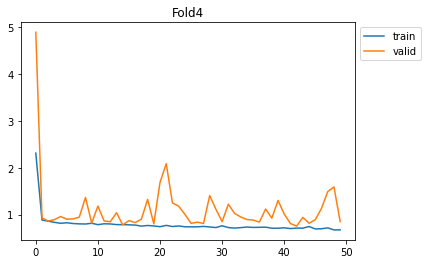

2021-07-20 22:30:56,218 - __main__ - DEBUG - Save training fold to ..\scripts\..\experiments\exp012\cv_fold4_training.csv (44324.174 seconds passed)
2021-07-20 22:30:56,218 - __main__ - DEBUG - Save validation fold to ..\scripts\..\experiments\exp012\cv_fold4_validation.csv (44324.174 seconds passed)
2021-07-20 22:30:56,234 - __main__ - DEBUG - Save test result ..\scripts\..\experiments\exp012\cv_fold4_test.csv (44324.189 seconds passed)
2021-07-20 22:30:56,328 - __main__ - DEBUG - Save model ..\scripts\..\experiments\exp012\cv_fold4_model.torch (44324.284 seconds passed)
2021-07-20 22:30:56,422 - __main__ - DEBUG - Complete fold 4 (44324.378 seconds passed)
2021-07-20 22:30:56,422 - __main__ - DEBUG - Start fold 5 (44324.378 seconds passed)
2021-07-20 22:30:56,422 - __main__ - DEBUG - Start training model (44324.378 seconds passed)
2021-07-20 22:30:56,564 - __main__ - DEBUG - Epoch 0/49
2021-07-20 22:34:16,034 - __main__ - DEBUG - train Loss: 2.2184
2021-07-20 22:34:34,380 - __main__ 

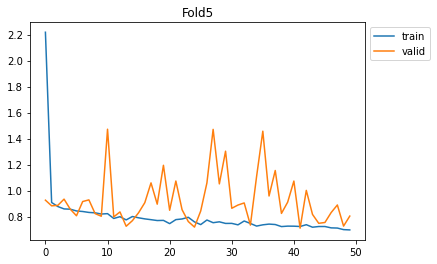

2021-07-21 01:35:21,547 - __main__ - DEBUG - Save training fold to ..\scripts\..\experiments\exp012\cv_fold5_training.csv (55389.503 seconds passed)
2021-07-21 01:35:21,547 - __main__ - DEBUG - Save validation fold to ..\scripts\..\experiments\exp012\cv_fold5_validation.csv (55389.503 seconds passed)
2021-07-21 01:35:21,563 - __main__ - DEBUG - Save test result ..\scripts\..\experiments\exp012\cv_fold5_test.csv (55389.519 seconds passed)
2021-07-21 01:35:21,610 - __main__ - DEBUG - Save model ..\scripts\..\experiments\exp012\cv_fold5_model.torch (55389.566 seconds passed)
2021-07-21 01:35:21,657 - __main__ - DEBUG - Complete fold 5 (55389.613 seconds passed)


In [18]:
fold_object_ids = load_cv_object_ids()
for i, (train_object_ids, valid_object_ids) in enumerate(zip(fold_object_ids[0], fold_object_ids[1])):
    assert(set(train_object_ids) & set(valid_object_ids) == set())
    num_fold = i + 1
    logger.debug('Start fold {} ({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))

    # Separate dataset into training/validation fold
    y_train = train.loc[train_object_ids, TARGET].values
    y_valid = train.loc[valid_object_ids, TARGET].values
    
    # Training
    logger.debug('Start training model ({:.3f} seconds passed)'.format(time.time() - SINCE))
    ## Prepare model
    model, input_size = initialize_model(MODEL_NAME)
    ## Prepare transformers
    train_transformer = transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    val_transformer = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    # Prepare dataset
    train_dataset = AtmaImageDatasetV02(train_object_ids, train_transformer, y_train)
    val_dataset = AtmaImageDatasetV02(valid_object_ids, val_transformer, y_valid)
    # Prepare dataloader
    dataloaders = {
        'train': DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count()),
        'val': DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count()),
    }
    ## train estimator
    estimator, train_losses, valid_losses = train_model(
        model, dataloaders, criterion=nn.MSELoss(), num_epochs=NUM_EPOCHS,
        optimizer=torch.optim.Adam(model.parameters()), log_func=logger.debug,
        is_inception=MODEL_NAME == 'inception')
    logger.debug('Complete training ({:.3f} seconds passed)'.format(time.time() - SINCE))
    ## Visualize training loss
    plt.plot(train_losses, label='train')
    plt.plot(valid_losses, label='valid')
    plt.legend(loc='upper left', bbox_to_anchor=[1., 1.])
    plt.title(f'Fold{num_fold}')
    plt.show()
    
    # Save model and prediction
    ## Prediction
    if REGRESSION:
        predictions = {}
        for fold_, object_ids_ in zip(['train', 'val', 'test'],
                                     [train_object_ids, valid_object_ids, test['object_id']]):
            # Prepare transformer
            transformer_ = transforms.Compose([
                transforms.Resize(input_size),
                transforms.CenterCrop(input_size),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
            # Prepare dataset
            dataset_ = AtmaImageDatasetV02(object_ids_, transformer_)
            # Prepare dataloader
            dataloader_ = DataLoader(dataset=dataset_, batch_size=BATCH_SIZE, shuffle=False,
                                     num_workers=os.cpu_count())
            # Prediction
            predictions[fold_] = predict_by_model(estimator, dataloader_)
        pred_train = pd.DataFrame(data=predictions['train'], columns=['pred'])
        pred_valid = pd.DataFrame(data=predictions['val'], columns=['pred'])
        pred_test = pd.DataFrame(data=predictions['test'], columns=['pred'])
    else:  # Do not come here!
        raise NotImplemented
        try:
            pred_train = pd.DataFrame(data=estimator.predict_proba(X_train),
                                      columns=estimator.classes_)
            pred_valid = pd.DataFrame(data=estimator.predict_proba(X_valid),
                                      columns=estimator.classes_)
            pred_test = pd.DataFrame(data=estimator.predict_proba(X_test),
                                     columns=estimator.classes_)
        except AttributeError:
            pred_train = pd.DataFrame(data=estimator.decision_function(X_train),
                                      columns=estimator.classes_)
            pred_valid = pd.DataFrame(data=estimator.decision_function(X_valid),
                                      columns=estimator.classes_)
            pred_test = pd.DataFrame(data=estimator.decision_function(X_test),
                                     columns=estimator.classes_)
    ## Training set
    pred_train['object_id'] = train_object_ids
    filepath_fold_train = os.path.join(output_dir, f'cv_fold{num_fold}_training.csv')
    pred_train.to_csv(filepath_fold_train, index=False)
    logger.debug('Save training fold to {} ({:.3f} seconds passed)' \
                .format(filepath_fold_train, time.time() - SINCE))
    ## Validation set
    pred_valid['object_id'] = valid_object_ids
    filepath_fold_valid = os.path.join(output_dir, f'cv_fold{num_fold}_validation.csv')
    pred_valid.to_csv(filepath_fold_valid, index=False)
    logger.debug('Save validation fold to {} ({:.3f} seconds passed)' \
                .format(filepath_fold_valid, time.time() - SINCE))
    ## Test set
    pred_test['object_id'] = test['object_id'].values
    filepath_fold_test = os.path.join(output_dir, f'cv_fold{num_fold}_test.csv')
    pred_test.to_csv(filepath_fold_test, index=False)
    logger.debug('Save test result {} ({:.3f} seconds passed)' \
                 .format(filepath_fold_test, time.time() - SINCE))
    ## Model
    filepath_fold_model = os.path.join(output_dir, f'cv_fold{num_fold}_model.torch')
    torch.save(estimator.state_dict(), filepath_fold_model)
#     with open(filepath_fold_model, 'wb') as f:
#         pickle.dump(estimator, f)
    logger.debug('Save model {} ({:.3f} seconds passed)'.format(filepath_fold_model, time.time() - SINCE))
    
    # Save memory
    del (estimator, y_train, y_valid, pred_train, pred_valid, pred_test)
    gc.collect()

    logger.debug('Complete fold {} ({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))

# Evaluation

In [19]:
rmse = partial(mean_squared_error, squared=False)

In [20]:
# qwk = partial(cohen_kappa_score, labels=np.sort(train['target'].unique()), weights='quadratic')

In [21]:
@np.vectorize
def predict(proba_0: float, proba_1: float, proba_2: float, proba_3: float) -> int:
    return np.argmax((proba_0, proba_1, proba_2, proba_3))

In [22]:
metrics = defaultdict(list)

## Training set

In [23]:
pred_train_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    logger.debug('Evaluate cv result (training set) Fold {}'.format(num_fold))
    # Read cv result
    filepath_fold_train = os.path.join(output_dir, f'cv_fold{num_fold}_training.csv')
    pred_train_df = pd.read_csv(filepath_fold_train)
    pred_train_df['actual'] = train.loc[pred_train_df['object_id'], TARGET].values
    if REGRESSION:
        if TARGET == 'target':
            pred_train_df['pred'].clip(lower=0, upper=3, inplace=True)
        else:
            pred_train_df['pred'] = np.vectorize(soring_date2target)(pred_train_df['pred'])
            pred_train_df['actual'] = np.vectorize(soring_date2target)(pred_train_df['actual'])
    else:
        pred_train_df['pred'] = predict(pred_train_df['0'], pred_train_df['1'],
                                        pred_train_df['2'], pred_train_df['3'])
    if not (REGRESSION and TARGET == 'target'):
        print(confusion_matrix(pred_train_df['actual'], pred_train_df['pred'],
                               labels=np.sort(train['target'].unique())))
    loss = rmse(pred_train_df['actual'], pred_train_df['pred'])
#     score = qwk(pred_train_df['actual'], pred_train_df['pred'])
    logger.debug('Loss: {}'.format(loss))
#     logger.debug('Score: {}'.format(score))
    metrics['train_losses'].append(loss)
#     metrics['train_scores'].append(score)
    pred_train_dfs.append(pred_train_df)

metrics['train_losses_avg'] = np.mean(metrics['train_losses'])
metrics['train_losses_std'] = np.std(metrics['train_losses'])
# metrics['train_scores_avg'] = np.mean(metrics['train_scores'])
# metrics['train_scores_std'] = np.std(metrics['train_scores'])

2021-07-21 01:35:21,752 - __main__ - DEBUG - Evaluate cv result (training set) Fold 1
2021-07-21 01:35:22,050 - __main__ - DEBUG - Loss: 0.8105381096033067
2021-07-21 01:35:22,050 - __main__ - DEBUG - Evaluate cv result (training set) Fold 2
2021-07-21 01:35:22,066 - __main__ - DEBUG - Loss: 0.8110304850219507
2021-07-21 01:35:22,066 - __main__ - DEBUG - Evaluate cv result (training set) Fold 3
2021-07-21 01:35:22,082 - __main__ - DEBUG - Loss: 0.7855444167880744
2021-07-21 01:35:22,082 - __main__ - DEBUG - Evaluate cv result (training set) Fold 4
2021-07-21 01:35:22,082 - __main__ - DEBUG - Loss: 0.7780640654407786
2021-07-21 01:35:22,082 - __main__ - DEBUG - Evaluate cv result (training set) Fold 5
2021-07-21 01:35:22,097 - __main__ - DEBUG - Loss: 0.8329358825055541


In [24]:
pred_train = pd.concat(pred_train_dfs).groupby('object_id').sum()
pred_train = pred_train / N_SPLITS
if not REGRESSION:
    pred_train['pred'] = predict(pred_train['0'], pred_train['1'], pred_train['2'], pred_train['3'])
pred_train['actual'] = train.loc[pred_train.index, TARGET].values
if REGRESSION and TARGET == 'sorting_date':
    pred_train['actual'] = np.vectorize(soring_date2target)(pred_train['actual'])
# for c in ('pred', 'actual'):
#     pred_train[c] = pred_train[c].astype('int')
pred_train

,pred,actual
object_id,,
002bff09b09998d0be65,1.10172,1
00309fb1ef05416f9c1f,1.83802,3
003a1562e97f79ba96dc,1.85150,3
004890880e8e7431147b,0.94285,2
00718c32602425f504c1,1.90438,3
...,...,...
ffa3259fff8e6f3818a1,1.55841,3
ffd4d361756587883e48,0.78167,1
ffd794b7b311b7b7fd92,1.91032,2


In [25]:
if not (REGRESSION and TARGET == 'target'):
    print(confusion_matrix(pred_train['actual'], pred_train['pred'], labels=np.sort(train['target'].unique())))
loss = rmse(pred_train['actual'], pred_train['pred'])
# score = qwk(pred_train['actual'], pred_train['pred'])
metrics['train_loss'] = loss
# metrics['train_score'] = score
logger.info('Training loss: {}'.format(loss))
# logger.info('Training score: {}'.format(score))

2021-07-21 01:35:22,160 - __main__ - INFO - Training loss: 0.8873520658503753


In [26]:
pred_train.to_csv(os.path.join(output_dir, 'prediction_train.csv'))
logger.debug('Write cv result to {}'.format(os.path.join(output_dir, 'prediction_train.csv')))

2021-07-21 01:35:22,192 - __main__ - DEBUG - Write cv result to ..\scripts\..\experiments\exp012\prediction_train.csv


## Validation set

In [27]:
pred_valid_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    logger.debug('Evaluate cv result (validation set) Fold {}'.format(num_fold))
    # Read cv result
    filepath_fold_valid = os.path.join(output_dir, f'cv_fold{num_fold}_validation.csv')
    pred_valid_df = pd.read_csv(filepath_fold_valid)
    pred_valid_df['actual'] = train.loc[pred_valid_df['object_id'], TARGET].values
    if REGRESSION:
        if TARGET == 'target':
            pred_valid_df['pred'].clip(lower=0, upper=3, inplace=True)
        else:
            pred_valid_df['pred'] = np.vectorize(soring_date2target)(pred_valid_df['pred'])
            pred_valid_df['actual'] = np.vectorize(soring_date2target)(pred_valid_df['actual'])
    else:
        pred_valid_df['pred'] = predict(pred_valid_df['0'], pred_valid_df['1'],
                                        pred_valid_df['2'], pred_valid_df['3'])        
    
    if not (REGRESSION and TARGET == 'target'):
        print(confusion_matrix(pred_valid_df['actual'], pred_valid_df['pred'],
                               labels=np.sort(train['target'].unique())))
    loss = rmse(pred_valid_df['actual'], pred_valid_df['pred'])
#     score = qwk(pred_valid_df['actual'], pred_valid_df['pred'])
    logger.debug('Loss: {}'.format(loss))
#     logger.debug('Score: {}'.format(score))
    metrics['valid_losses'].append(loss)
#     metrics['valid_scores'].append(score)
    pred_valid_dfs.append(pred_valid_df)
    
metrics['valid_losses_avg'] = np.mean(metrics['valid_losses'])
metrics['valid_losses_std'] = np.std(metrics['valid_losses'])
# metrics['valid_scores_avg'] = np.mean(metrics['valid_scores'])
# metrics['valid_scores_std'] = np.std(metrics['valid_scores'])

2021-07-21 01:35:22,223 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 1
2021-07-21 01:35:22,238 - __main__ - DEBUG - Loss: 0.8379114606952209
2021-07-21 01:35:22,238 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 2
2021-07-21 01:35:22,243 - __main__ - DEBUG - Loss: 0.848367281755134
2021-07-21 01:35:22,243 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 3
2021-07-21 01:35:22,255 - __main__ - DEBUG - Loss: 0.8103946967027115
2021-07-21 01:35:22,255 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 4
2021-07-21 01:35:22,270 - __main__ - DEBUG - Loss: 0.8678550273610941
2021-07-21 01:35:22,270 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 5
2021-07-21 01:35:22,270 - __main__ - DEBUG - Loss: 0.8433184409332284


In [28]:
pred_valid = pd.concat(pred_valid_dfs).groupby('object_id').sum()
pred_valid = pred_valid / N_SPLITS
if not REGRESSION:
    pred_valid['pred'] = predict(pred_valid['0'], pred_valid['1'], pred_valid['2'], pred_valid['3'])
pred_valid['actual'] = train.loc[pred_valid.index, TARGET].values
if REGRESSION and TARGET == 'sorting_date':
    pred_valid['actual'] = np.vectorize(soring_date2target)(pred_valid['actual'])
# for c in ('pred', 'actual'):
#     pred_valid[c] = pred_valid[c].astype('int')
pred_valid

,pred,actual
object_id,,
002bff09b09998d0be65,0.22289,1
00309fb1ef05416f9c1f,0.43376,3
003a1562e97f79ba96dc,0.40468,3
004890880e8e7431147b,0.14016,2
00718c32602425f504c1,0.41116,3
...,...,...
ffa3259fff8e6f3818a1,0.32199,3
ffd4d361756587883e48,0.19970,1
ffd794b7b311b7b7fd92,0.53639,2


In [29]:
if not REGRESSION:
    print(confusion_matrix(pred_valid['actual'], pred_valid['pred'], labels=np.sort(train['target'].unique())))
loss = rmse(pred_valid['actual'], pred_valid['pred'])
# score = qwk(pred_valid['actual'], pred_valid['pred'])
metrics['valid_loss'] = loss
# metrics['valid_score'] = score
logger.info('Validatino loss: {}'.format(loss))
# logger.info('Validatino score: {}'.format(score))

2021-07-21 01:35:22,333 - __main__ - INFO - Validatino loss: 1.7150954262821403


In [30]:
pred_valid.to_csv(os.path.join(output_dir, 'prediction_valid.csv'))
logger.debug('Write cv result to {}'.format(os.path.join(output_dir, 'prediction_valid.csv')))

2021-07-21 01:35:22,350 - __main__ - DEBUG - Write cv result to ..\scripts\..\experiments\exp012\prediction_valid.csv


In [31]:
with open(os.path.join(output_dir, 'metrics.json'), 'w') as f:
    json.dump(dict(metrics), f)
logger.debug('Write metrics to {}'.format(os.path.join(output_dir, 'metrics.json')))

2021-07-21 01:35:22,381 - __main__ - DEBUG - Write metrics to ..\scripts\..\experiments\exp012\metrics.json


# Prediction

In [32]:
pred_test_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    # Read cv result
    filepath_fold_test = os.path.join(output_dir, f'cv_fold{num_fold}_test.csv')
    pred_test_df = pd.read_csv(filepath_fold_test)
    pred_test_dfs.append(pred_test_df)

In [33]:
pred_test = pd.concat(pred_test_dfs).groupby('object_id').sum()
pred_test = pred_test / N_SPLITS
if REGRESSION:
    if TARGET == 'target':
        pred_test['pred'].clip(lower=0, upper=3, inplace=True)
    else:
        pred_test['pred'] = np.vectorize(soring_date2target)(pred_test['pred'])
else:
    pred_test['pred'] = predict(pred_test['0'], pred_test['1'], pred_test['2'], pred_test['3'])
pred_test

,pred
object_id,
0009e50b94be36ccad39,1.38151
000bd5e82eb22f199f44,2.12472
0015f44de1854f617516,1.74514
00388a678879ba1efa27,2.05267
005e1e7c6496902d23f3,0.75759
...,...
ffbe65ad399b632dcbd0,2.09462
ffd7b2d646c0320c311a,1.01437
ffdb93ede17d4501e530,1.68707


In [34]:
test['target'] = pred_test.loc[test['object_id'], 'pred'].values
test = test[['target']]
test

,target
0,1.38151
1,2.12472
2,1.74514
3,2.05267
4,0.75759
...,...
5914,2.09462
5915,1.01437
5916,1.68707
5917,1.77674


In [35]:
sample_submission

,target
0,3
1,1
2,3
3,3
4,0
...,...
5914,2
5915,1
5916,1
5917,3


In [36]:
test.to_csv(os.path.join(output_dir, f'{str(EXP_NO).zfill(3)}_submission.csv'), index=False)
logger.debug('Write submission to {}'.format(os.path.join(output_dir, f'{str(EXP_NO).zfill(3)}_submission.csv')))

2021-07-21 01:35:22,544 - __main__ - DEBUG - Write submission to ..\scripts\..\experiments\exp012\012_submission.csv


2021-07-21 01:35:22,664 - __main__ - DEBUG - Write figure to ..\scripts\..\experiments\exp012\prediction.png


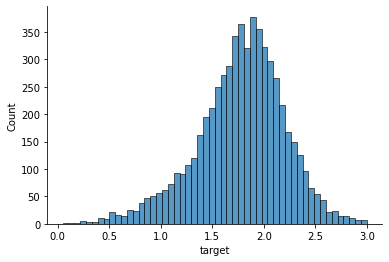

In [37]:
fig = plt.figure()
if not (REGRESSION and TARGET == 'target'):
    sns.countplot(data=test, x='target')
else:
    sns.histplot(data=test, x='target')
sns.despine()
fig.savefig(os.path.join(output_dir, 'prediction.png'))
logger.debug('Write figure to {}'.format(os.path.join(output_dir, 'prediction.png')))

In [38]:
logger.debug('Complete ({:.3f} seconds passed)'.format(time.time() - SINCE))

2021-07-21 01:35:22,758 - __main__ - DEBUG - Complete (55390.714 seconds passed)
